# One-dim experiments

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import time
import plot
from svgd import SVGD

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# dist = metrics.Gaussian(0, 1)
# dist = metrics.GaussianMixture([-3, 3], [1, 1], [1/3, 2/3])
dist = metrics.Gaussian(0, 6)

n = 100
d = dist.d

n_steps = 1000
svgd = SVGD(dist, n_steps, particle_shape=(n, d), adagrad=False)

In [3]:
h = 1

In [4]:
ksd_bandwidth = None
lr = 0.01
svgd_stepsize = 1
bandwidth = h

In [5]:
*rkeys, rkey = random.split(rkey, 4)
rkey = random.split(rkey)[0]

### train

In [6]:
st = time.time()
x, log, losses = svgd.train(rkey, h, lr, svgd_stepsize, n_steps, ksd_bandwidth, update_after=0)
x.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")
print(log["desc"]["bandwidth"][-4:][:, 0])

  0%|          | 1/1000 [00:01<27:38,  1.66s/it]

JIT COMPILING step...
...done compiling step after 0.3935413360595703 seconds.


100%|██████████| 1000/1000 [00:25<00:00, 39.27it/s]

took 25.79094886779785 seconds
[0.14660719 0.14514843 0.14370418 0.1422743 ]


In [7]:
st = time.time()
x0 = svgd.initialize(rkey)
xs, logs = svgd.svgd(x0, svgd_stepsize, h, n_steps)
end = time.time()
print(f"took {end - st} seconds")

JIT COMPILING svgd...
...done compiling svgd after 0.8739004135131836 seconds.
took 4.7509002685546875 seconds


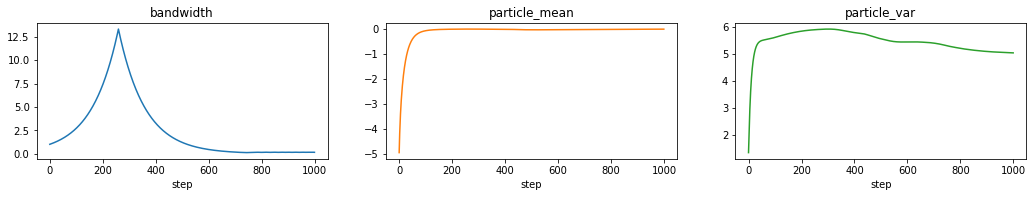

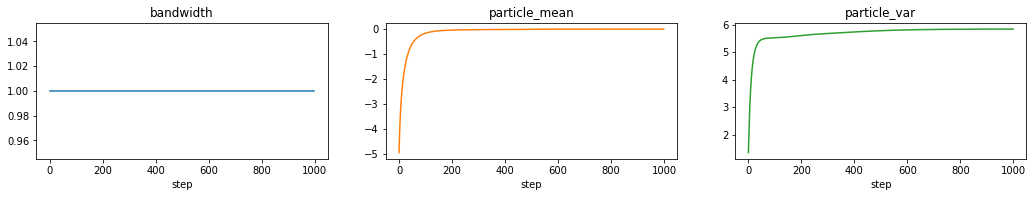

In [8]:
plot.svgd_log(log)#, full=True)
plot.svgd_log(logs)

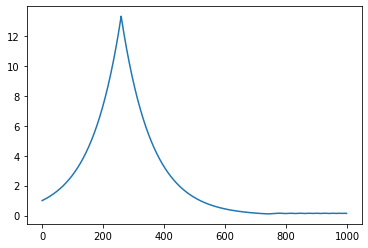

In [9]:
plt.plot(log["ksd_hs"])

# Histograms

In [10]:
s = dist.sample(shape=(n,1))

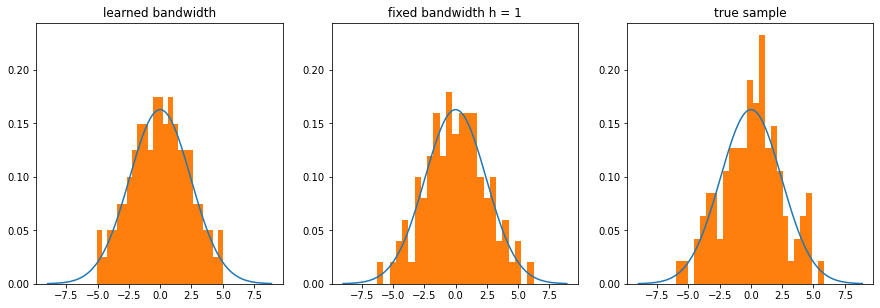

In [11]:
grid = np.arange(-9, 9, 0.1)

fig, axs = plt.subplots(1, 3, figsize = [15, 4.8])
for ax, out, title in zip(axs, (x, xs, s), ("learned bandwidth", f"fixed bandwidth h = {h}", "true sample")):
    _ = ax.plot(grid, vmap(dist.pdf)(grid))
    _ = ax.hist(out[:, 0], density=True, bins=25)
    _ = ax.set_title(title)

_ = plot.equalize_axes(axs)

In [12]:
print("svgd_h = ", bandwidth)
print("--------------")
for h in (1, 100, 1000):
    print("h = ", h)
    print(metrics.ksd(xs, dist.logpdf, h))
    print()

svgd_h =  1
--------------
h =  1
3.4423912e-05

h =  100
8.3050104e-08

h =  1000
1.2976306e-08



In [13]:
print("svgd_h = ", bandwidth)
print("--------------")
for h in (1, 100, 1000):
    print("h = ", h)
    print(metrics.ksd(xs, dist.logpdf, h))
    print()

svgd_h =  1
--------------
h =  1
3.4423912e-05

h =  100
8.3050104e-08

h =  1000
1.2976306e-08



In [14]:
print("svgd_h = ", bandwidth)
print("--------------")
for h in (1, 100, 1000):
    print("h = ", h)
    print(metrics.ksd(xs, dist.logpdf, h))
    print()

svgd_h =  1
--------------
h =  1
3.4423912e-05

h =  100
8.3050104e-08

h =  1000
1.2976306e-08



# 1d scatterplot

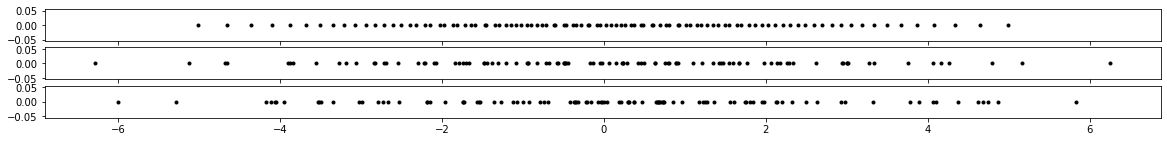

In [15]:
figs, axs = plt.subplots(3, figsize=[20, 2])
# figs.tight_layout = True

titles = ["Learned", "Fixed", "True random"]
samples = [x[:, 0], xs[:, 0], s]
mins = []
maxs = []

for ax, t, sam in zip(axs, titles, samples):
    ax.plot(sam, np.zeros(n), "k.")
#     ax.set_title(t)
    lims = ax.get_xlim()
    mins.append(lims[0])
    maxs.append(lims[1])

lims = [min(mins), max(maxs)]
for ax in axs:
    ax.set_xlim(lims)